In [19]:
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

from FileMangement import *

import os
from ggplot import *
import seaborn as sns
import pandas as pd

In [2]:
def rgb2gray(rgb):
    # Sets each pixel to a weighted value
    grayed = 0.2126 * rgb[:,:,0] + 0.7152 * rgb[:,:,1] + 0.0722 * rgb[:,:,2]
    return grayed

In [3]:
# Mask is a zero matrix
# fillMask fills an empty numpy array with 255 for pixels that fits inside the defined triangle
def fillMask(mask):
    h, w = mask.shape
    bottom_left = (h, 0)
    middle = (int(h/2), int(w/2))
    bottom_right = (h, w)
    
    for x, row in enumerate(mask):
        for y, col in enumerate(row):
            # Applying equations to left_bound and right_bound
            left_bound = (h - x) * middle[1] / middle[0]
            right_bound = x * middle[1] / middle[0]
            if y > left_bound and y < right_bound and x <= 400:
                mask[x][y] = 255
                
    return mask

In [4]:
# For each non-zero pixel in mask, the corresponding pixel on image is kept (the rest of the pixels in mask is discarded)
def apply_mask(image, mask):
    for x, row in enumerate(mask):
        for y, col in enumerate(row):
            if mask[x][y] != 255:
                image[x][y] = 0
    return image

In [5]:
# Rohit's Otsu's Implementation
def otsu_thresh(input_im):          
    # Set total number of bins in the histogram
    bins_num = int(np.amax(input_im)) + 1
    print(f'Number of bins = {bins_num}')

    # Get the image histogram
    hist, bin_edges = np.histogram(input_im, bins=bins_num, range=(0, bins_num))

    # normalize histogram
    hist = np.divide(hist.ravel(), hist.max())

    # Calculate centers of bins
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

    # Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]

    # Get the class means mu0(t)
    mean1 = np.cumsum(hist * bin_mids) / weight1
    # Get the class means mu1(t)
    mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]

    inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

    # Maximize the inter_class_variance function val
    index_of_max_val = np.argmax(inter_class_variance)

    threshold = bin_mids[:-1][index_of_max_val]
    
    print(f'Threshold = {threshold}')         

    return threshold

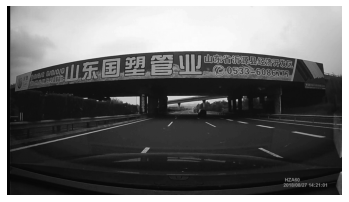

In [283]:
video_num = '0250'

frame_num = 600


pil_im = Image.open(get_image(video_num, frame_num))
orig = np.array(pil_im)

# Resize so that standard height is 512
width = int(pil_im.width * 512 / pil_im.height)
pil_im = pil_im.resize((width , 512))

# Convert to np array
orig_img = np.array(pil_im)
# plt.imshow(orig_img)
# plt.show()

#Convert to grayscale
im = rgb2gray(orig_img)

# Deletes the 1 and 2 indices from the rgb parameter so the array can be squeezed
# im = np.delete(im, [1, 2], 2)

plt.imshow(im, cmap='gray')
plt.axis('off')
plt.show()

(5, 5)
(516, 914)
(512, 910)


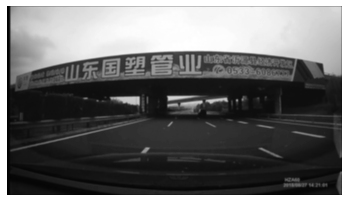

In [284]:
# Tharm's image smoothing
#Implementing image smoothing
rows = im.shape[0]
cols = im.shape[1]

#input any kernel size
kernel_shape_row = 5
kernel_shape_col = 5

kernel = np.ones((kernel_shape_row, kernel_shape_col))/(kernel_shape_row * kernel_shape_col)
mag_smooth = np.zeros((rows,cols))
print(kernel.shape)

#pad with zeros on the border for full blurring of image
padded_gray = np.zeros((rows + kernel_shape_row - 1, cols + kernel_shape_col - 1))
index_1_row = (int) ((kernel_shape_row - 1)/2)
index_last_row = (int) (rows + ((kernel_shape_row - 1)/2))
index_1_col = (int) ((kernel_shape_col - 1)/2)
index_last_col = (int) (cols + ((kernel_shape_col - 1)/2))
padded_gray[index_1_row:index_last_row, index_1_col:index_last_col] = im
print(padded_gray.shape)

for x in range(rows):
    for y in range(cols):
        mag_smooth[x][y] = (kernel * padded_gray[x:x+kernel_shape_row, y:y+kernel_shape_col]).sum()     
        
print(mag_smooth.shape)
plt.imshow(mag_smooth, cmap='gray')
plt.axis('off')
plt.show()

(512, 910)
finished making new image
(512, 910)


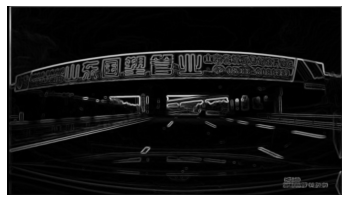

In [285]:
# Tharm's Sobel Edge Detector
## Implementing sobel edge detector
Gx = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
Gy = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

mag_G = np.zeros((rows,cols))
#mag_G_thresh = np.zeros((rows,cols))
print(mag_G.shape)

for i in range(1, rows - 1):
    for j in range(1, cols - 1):
        sumx = (Gx * mag_smooth[i-1:i+2, j-1:j+2]).sum()
        sumy = (Gy * mag_smooth[i-1:i+2, j-1:j+2]).sum()
        mag_G[i][j] = np.sqrt(sumx**2 + sumy**2)
        
print('finished making new image')
print(mag_G.shape)
plt.imshow(mag_G, cmap='gray')
plt.axis('off')
plt.show()

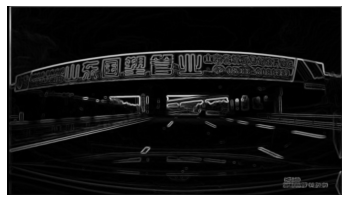

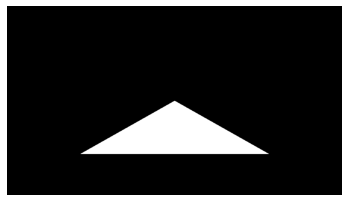

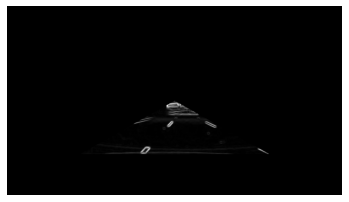

In [286]:
# Own implementation of cropped image
plt.imshow(mag_G, cmap='gray')
plt.axis('off')
plt.show()
mask = np.zeros_like(mag_G)
mask = fillMask(mask)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()
cropped_im = apply_mask(mag_G, mask)
plt.imshow(cropped_im, cmap='gray')
plt.axis('off')
plt.show()

In [287]:
threshold = otsu_thresh(cropped_im)

Number of bins = 277
Threshold = 61.5


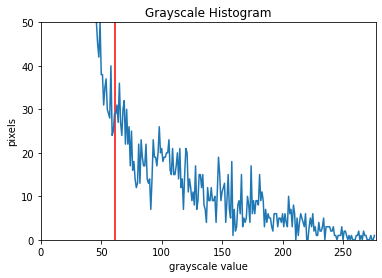

In [288]:
##Making histogram of threshold

maxValue = int(np.amax(cropped_im)) + 1

histogram, bin_edges = np.histogram(cropped_im, bins=maxValue, range=(0,maxValue))
# configure and draw the histogram figure
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0, maxValue])
plt.ylim([0, 50]) # must be changed manually after generating once for better visual analysis
plt.vlines(threshold, 0, 200, colors = 'r')

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

(512, 910)
thresholding done
(512, 910)


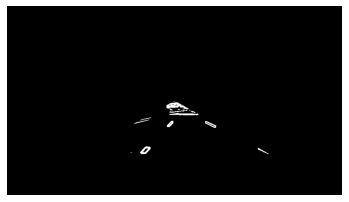

In [289]:
##Thresholding

threshImage = np.zeros((rows, cols))
print(threshImage.shape)

for i in range(1, rows - 1):
    for j in range(1, cols - 1):
        if cropped_im[i][j] < threshold:
            threshImage[i][j] = 0
        else:
            threshImage[i][j] = 255

print('thresholding done')
print(threshImage.shape)
plt.imshow(threshImage, cmap = 'gray')
plt.axis('off')
plt.show()

In [290]:
# Rohit's code
def Hough_lines(img, line_length):

    height, width = img.shape[:2]
    
    # Creates the accumulator space
    accumulator = np.zeros([180, int(math.sqrt(height ** 2 + width ** 2))])

    lines = np.array([[0, 0], [0, 0]])

    #line_length = 40

    # look for every pixel
    for y in range(0, height):
        for x in range(0, width):
            # if pixel is white (possible part of a line)
            if img[y][x] > 250:
                # try all angles
                # Step = 3 to decrease number of lines
                for theta in range(0, 180, 1):
                    p = int(x * math.cos(math.radians(theta)) + y * math.sin(math.radians(theta)))
                    accumulator[theta][p] += 1
                    # Check if it looks like line and if it's not in a list
                    if (accumulator[theta][p] > line_length) and (p not in lines[:, 0]) and (theta not in  lines[:, 1]):
                        # lines is an array of [rho, theta] pairs that has a lot of points in the accumulator space
                        lines = np.vstack((lines, np.array([p, theta])))

    # clean two first zeros
    lines = np.delete(lines, [0, 1], axis=0)
    
#     print(lines)

    return accumulator, lines

In [291]:
# Rohit's code
# Outputs 2 different points on the line to draw the line
def hough_intersect (rho, theta, image):
    h, w = image.shape[:2]
    out = []
    theta = math.radians(theta)
    intersect = [int(round(rho / math.sin(theta))), int(round((rho - w * math.cos(theta)) / math.sin(theta))), int(round(rho / math.cos(theta))),
                 int(round((rho - h * math.sin(theta)) / math.cos(theta)))]
    
    
    # Use formula to get 2 points in a line, one being 100 pixels from left and another being 100 pixels from right
    x1 = 100
    y1 = int(x1 * (-math.cos(theta)/math.sin(theta)) + rho / math.sin(theta))
    
    x2 = 800
    y2 = int(x2 * (-math.cos(theta)/math.sin(theta)) + rho / math.sin(theta))
    out.append((x1, y1))
    out.append((x2, y2))
    
    return out

In [312]:
hough_space, point_stack = Hough_lines(threshImage, 50)

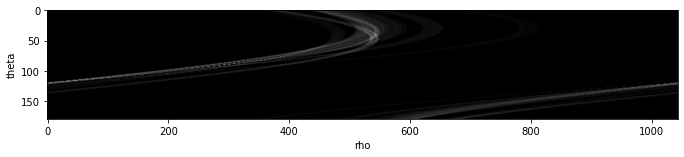

In [313]:
plt.figure(figsize = (20,2))
plt.imshow(hough_space, cmap='gray')
plt.xlabel('rho')
plt.ylabel('theta')
plt.show()

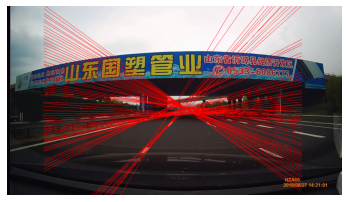

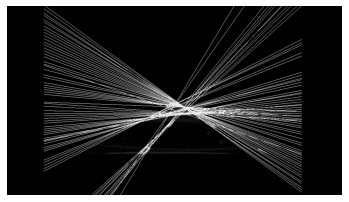

In [314]:
points_coord = [] #To store the coordinates of the lines
orig_line = orig_img.copy()
edge_line = cropped_im.copy()

for i in point_stack:
    points = hough_intersect(i[0], i[1], orig)
#     print(points)
    if (len(points) > 1):
        points_coord.append([list(point) for point in points])
        cv.line(orig_line, points[0], points[1], (255,0,0))
        cv.line(edge_line, points[0], points[1], (255,255,255))

fig = plt.imshow(orig_line)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

plt.show()
plt.imshow(edge_line, cmap="gray")
plt.axis('off')
plt.show()

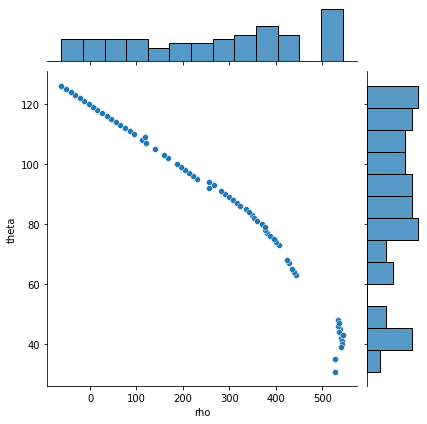

In [321]:
df = pd.DataFrame({'rho':point_stack[:,0], 'theta':point_stack[:,1]})
bin_size = 13
sns.jointplot(data=df,x='rho',y='theta',marginal_kws=dict(bins=bin_size))

In [322]:
hist_rho, edges_rho = np.histogram(df['rho'].tolist(), bins=10)
cumsum_rho = np.cumsum(hist_rho)
hist_theta, edges_theta = np.histogram(df['theta'].tolist(), bins=10)
cumsum_theta = np.cumsum(hist_theta)

In [323]:
def groupContious(arr):
    arr.sort()
    i = 0
    rtn_arr = []
    while i < len(arr):
        start_i = arr[i]
        end_i = arr[i]
        while i < len(arr)-1 and arr[i] == arr[i+1]-1:
            end_i = arr[i+1]
            i += 1
        rtn_arr.append((start_i,end_i))
        i += 1
    return rtn_arr

In [324]:
rho_peeks = []
theta_peeks = []

if hist_rho[0] != 0 and hist_rho[0] >= hist_rho[1]:
    rho_peeks.append(0)

if hist_rho[-1] != 0 and hist_rho[-1] >= hist_rho[-2]:
    rho_peeks.append(len(hist_rho)-1)

if hist_theta[0] != 0 and hist_theta[0] >= hist_theta[1]:
    theta_peeks.append(0)

if hist_theta[-1] != 0 and hist_theta[-1] >= hist_theta[-2]:
    theta_peeks.append(len(hist_theta)-1)

for i in range(1, len(hist_rho)-1):
    if hist_rho[i] != 0 and hist_rho[i] >= hist_rho[i-1] and hist_rho[i] >= hist_rho[i+1]:
        rho_peeks.append(i)
    if hist_theta[i] != 0 and hist_theta[i] >= hist_theta[i-1] and hist_theta[i] >= hist_theta[i+1]:
        theta_peeks.append(i)
        
rho_peeks = groupContious(rho_peeks)
theta_peeks = groupContious(theta_peeks)

In [325]:
theta_peeks

[(1, 1), (6, 6), (8, 9)]

In [326]:
cleaned_point_stack = []

for rho_split in rho_peeks:
    rho_min, rho_max = edges_rho[rho_split[0]], edges_rho[rho_split[1]+1]
#     print(f'Between rho: [{rho_min}, {rho_max}]')
    matched_rho = df[df['rho'].between(rho_min, rho_max)]
    
    for theta_split in theta_peeks:
        theta_min, theta_max = edges_theta[theta_split[0]], edges_theta[theta_split[1]+1]
#         print(f'Between theta: [{theta_split[0]}, {theta_split[1]+1}]')
        
        matched_rho_theta =  df[df['theta'].between(theta_min, theta_max)]
        
        if matched_rho_theta.size != 0:
            sub_df_mean = matched_rho_theta.mean()
            cleaned_point_stack.append([sub_df_mean['rho'], sub_df_mean['theta']])
    

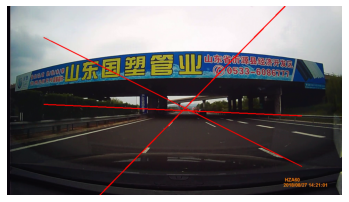

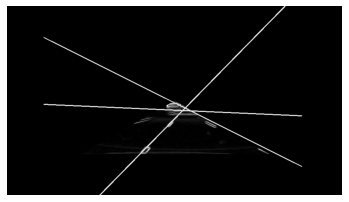

In [327]:
points_coord = [] #To store the coordinates of the lines
orig_line = orig_img.copy()
edge_line = cropped_im.copy()

for i in cleaned_point_stack:
    points = hough_intersect(i[0], i[1], orig)
#     print(points)
    if (len(points) > 1):
        points_coord.append([list(point) for point in points])
        cv.line(orig_line, points[0], points[1], (255,0,0),2)
        cv.line(edge_line, points[0], points[1], (255,255,255),2)

fig = plt.imshow(orig_line)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

plt.show()
plt.imshow(edge_line, cmap="gray")
plt.axis('off')
plt.show()

In [301]:
test = hough_intersect(443, 69, orig)

In [302]:
points_coord = [] #To store the coordinates of the lines
lines = []

for i in point_stack:
    points = hough_intersect(i[0], i[1], orig)
    if (len(points) > 1):
        points_coord.append([list(point) for point in points])
        lines.append((points[0], points[1]))

intersect = [0, 0, 0, 0]
intersect_count= [0, 0, 0, 0]

h, w = orig_img.shape[:2]

print(lines)

for line in lines:
    # Check which lane the line represents and add value to intersect to get total
    if line[0][1] > h/2:
        intersect[0] += line[0][1]
        intersect_count[0] += 1
    else:
        intersect[1] += line[0][1]
        intersect_count[1] += 1
    
    if line[1][1] > h/1:
        intersect[2] += line[1][1]
        intersect_count[2] += 1
    else:
        intersect[3] += line[1][1]
        intersect_count[3] += 1
        
# Divide total added values of each point by count to get average        
for i, total in enumerate(intersect):
    intersect[i] = int(total / intersect_count[i])

print(intersect)

# Calculate the 2 slopes
m1 = (intersect[3] - intersect[0]) / 700  # positive slope
m2 = (intersect[2] - intersect[1]) / 700  # negative slope

print(m1, m2)

# Calculate y intercept
c1 = intersect[0] - m1 * 100
c2 = intersect[1] - m2 * 100
print(c1, c2)

# Solve system of equations to get intersection point/vanishing point
A = np.array([[-m1, 1], [-m2, 1]])
B = np.array([c1, c2])
C = np.linalg.solve(A, B)
print(C)

# Draw 2 average lines for each lane with vanishing point
cv.line(orig_img, (100, intersect[0]), (int(C[0]), int(C[1])), (255,0,0), thickness=2)
cv.line(orig_img, (int(C[0]), int(C[1])), (800, intersect[2]), (255,0,0), thickness=2)
    
plt.imshow(orig_img)
plt.axis('off')
plt.show()

[((100, 239), (800, 300)), ((100, 232), (800, 306)), ((100, 226), (800, 312)), ((100, 260), (800, 285)), ((100, 220), (800, 318)), ((100, 214), (800, 325)), ((100, 193), (800, 341)), ((100, 150), (800, 377)), ((100, 171), (800, 359)), ((100, 157), (800, 371)), ((100, 207), (800, 330)), ((100, 186), (800, 347)), ((100, 97), (800, 423)), ((100, 88), (800, 430)), ((100, 121), (800, 404)), ((100, 113), (800, 410)), ((100, 129), (800, 398)), ((100, 104), (800, 416)), ((100, 70), (800, 442)), ((100, 79), (800, 435)), ((100, 137), (800, 392)), ((100, 291), (800, 290)), ((100, 283), (800, 296)), ((100, 297), (800, 285)), ((100, 62), (800, 450)), ((100, 304), (800, 280)), ((100, 311), (800, 274)), ((100, 271), (800, 308)), ((100, 263), (800, 312)), ((100, 54), (800, 458)), ((100, 43), (800, 464)), ((100, 317), (800, 268)), ((100, 327), (800, 266)), ((100, 338), (800, 252)), ((100, 333), (800, 259)), ((100, 343), (800, 245)), ((100, 367), (800, 206)), ((100, 348), (800, 237)), ((100, 363), (800,

ZeroDivisionError: division by zero